In [1]:
import pyvista
import PyQt5

import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
                              read_inverse_operator, make_inverse_operator)
from mne.connectivity import seed_target_indices, spectral_connectivity
import matplotlib.pyplot as plt

print(__doc__)

Automatically created module for IPython interactive environment


### Choose location & vertice index

In [2]:
location = "Vis-rh"
vertice_index = 2

# EEG analyzation

### Load data and drop MEG samples

In [3]:
# Fetch path of sample data
data_path = sample.data_path()
print("Data path: " + data_path)

# Add subjects directory to data path
subjects_dir = data_path + '/subjects'
print(data_path)

# Add correct sub-paths to global path 
fname_fwd = data_path + '/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif'
fname_cov = data_path + '/MEG/sample/sample_audvis-cov.fif'
fname_evo = data_path + '/MEG/sample/sample_audvis-ave.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Assign variable defined above to label name - controls which location we want to analyze
label_name = location
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name


# read forward solution 
fwd = mne.read_forward_solution(fname_fwd)

# noise covariance matrix
noise_cov = mne.read_cov(fname_cov)

# evoked data for info
evoked = mne.read_evokeds(fname_evo, 0)
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Remove EEG 053 channel in case 60 elements are required
raw.info["bads"].remove("EEG 053")

# pick EEG channels.
picks = mne.pick_types(raw.info, eeg=True, meg=False)

# Assign id of the event to consider, start time before epochs & end time after epochs
event_id, tmin, tmax = 1, -0.2, 0.5

# use dSPM method (could also be MNE or sLORETA)
method = "dSPM"  

# Read epochs.
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0),
                    reject=dict(eeg=150e-6))

Data path: /Users/oonacromheecke/mne_data/MNE-sample-data
/Users/oonacromheecke/mne_data/MNE-sample-data
Reading forward solution from /Users/oonacromheecke/mne_data/MNE-sample-data/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading /Users/oonacromheecke/mne_da

In [4]:
# print epoch info 
epochs.info

<Info | 14 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 60
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on, Average EEG reference: on
 sfreq: 150.2 Hz
>

In [5]:
print(f"Number of elements in picks: {len(picks)}")
print(f"Number of channels: {len(epochs.ch_names)}")

Number of elements in picks: 60
Number of channels: 60


In [6]:
# Signal to Noise ratio
snr = 3.0
# lambda == regularization parameter
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)

print(f"Vertex index with most power: {np.argmax(src_pow)}")

# Uncomment (& comment out next line) if I want to get the index with highest power
# seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]

# variable "vertice_index" defined in cell above
# NOTE: For the first index: if location == lh --> 0 ; if location == rh --> 1 !
seed_vertno = stc_label.vertices[1][vertice_index]

# Search for index in orig stc
seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  

# first dimension of data indicates number of sources == number of dipoles == rows
# second dimension of data indicates number of points
n_sources = stc.data.shape[0]
# Generate index parameter for seed-based connectivity analysis.
indices = seed_target_indices([seed_idx], np.arange(n_sources))

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 72
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 58 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 59 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  87.7% variance
    dSPM...
[done]
Vertex index with most power: 2


In [7]:
# use lower SNR for single epochs
snr = 1.0
# adapt regularization parameter
lambda2 = 1.0 / snr ** 2
# Apply inverse operator once more
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [8]:
# define lower and upper frequency of interest
fmin = (8., 13.)
fmax = (13., 30.)
# the sampling frequency
sfreq = raw.info['sfreq']


'''
function returns respectively:
- computed connectivity measures
- frequency points at which the connectivity was computed
- time points for which the connectivity was computed
- number of epochs needed
'''

coh_eeg, freqs, times, n_epochs, _ = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 58 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 59 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
    computing connectivity for 7498 connections
    using t=-0.200s..0.499s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 8.5Hz..12.7Hz (4 points)
     band 2: 14.2Hz..29.7Hz (12 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
Processing epoch : 2 / 72 (at most)
    computing connectiv

### Visualize

In [9]:
%matplotlib inline

# minimum time to plot
tmin = np.mean(freqs[0])
# size of steps taken in plot
tstep = np.mean(freqs[1]) - tmin
coh_stc = mne.SourceEstimate(coh_eeg, vertices=stc.vertices, tmin=1e-3 * tmin,
                             tstep=1e-3 * tstep, subject='sample')

# Now we can visualize the coherence using the plot method.
brain = coh_stc.plot('sample', 'inflated', 'both',
                     time_label='Coherence %0.1f Hz',
                     subjects_dir=subjects_dir,
                     clim=dict(kind='value', lims=(0.25, 0.4, 0.65)))
brain.show_view('lateral')

Using mayavi 3d backend.



((-7.016709298534877e-15,
  90.0,
  527.091796875,
  array([-0.53098297,  0.        ,  0.        ])),
 -90.0)

# MEG analyzation

In [10]:
# Fetch path of sample data
data_path = sample.data_path()
print("Data path: " + data_path)

# Add subjects directory to data path
subjects_dir = data_path + '/subjects'
print(data_path)

# Add correct sub-paths to global path 
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Assign variable defined above to label name - controls which location we want to analyze
label_name = location
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name



# Read inverse operator
inverse_operator = read_inverse_operator(fname_inv)
# Read labels
label = mne.read_label(fname_label)
# Read raw data
raw = mne.io.read_raw_fif(fname_raw)
# Read events
events = mne.read_events(fname_event)

# Remove EEG 053 & MEG 2443 from bads - as we do not assume these are bads
raw.info["bads"].remove("MEG 2443")

# pick MEG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

# Assign id of the event to consider, start time before epochs & end time after epochs
event_id, tmin, tmax = 1, -0.2, 0.5

# use dSPM method (could also be MNE or sLORETA)
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Read epochs.
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0),
                    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))

Data path: /Users/oonacromheecke/mne_data/MNE-sample-data
/Users/oonacromheecke/mne_data/MNE-sample-data
Reading inverse operator decomposition from /Users/oonacromheecke/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patc

In [11]:
len([x for x in epochs.ch_names if "MEG" in x])

306

In [12]:
# print epoch info
epochs.info

<Info | 14 non-empty values
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 307
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on, Average EEG reference: on
 sfreq: 150.2 Hz
>

In [13]:
print(f"Number of elements in picks: {len(picks)}")
print(f"Number of channels: {len(epochs.ch_names)}")

Number of elements in picks: 307
Number of channels: 307


In [14]:
# Signal to Noise ratio
snr = 3.0
# lambda == regularization parameter
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)
print(f"Vertex index with most power: {np.argmax(src_pow)}")

# Uncomment (& comment out next line) if I want to get the index with highest power
seed_vertno = stc_label.vertices[1][np.argmax(src_pow)]

# variable "vertice index" defined in cell above
# comment out (& uncomment previous line) if I want to get the index with highest power
# seed_vertno = stc_label.vertices[0][vertice_index]

# Search for index in orig stc
seed_idx = np.searchsorted(stc.vertices[1], seed_vertno)  # index in orig stc

# first dimension of data indicates number of sources == number of dipoles == rows
# second dimension of data indicates number of points
n_sources = stc.data.shape[0]
# Generate index parameter for seed-based connectivity analysis.
indices = seed_target_indices([seed_idx], np.arange(n_sources))

    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting  epoch based on GRAD : ['MEG 2443']
    Rejecting

In [15]:
# use lower SNR for single epochs
snr = 1.0
# adapt regularization parameter
lambda2 = 1.0 / snr ** 2
# Apply inverse operator once more
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [16]:
# define lower and upper frequency of interest
fmin = (8., 13.)
fmax = (13., 30.)
# the sampling frequency
sfreq = raw.info['sfreq']


'''
function returns respectively:
- computed connectivity measures
- frequency points at which the connectivity was computed
- time points for which the connectivity was computed
- number of epochs needed
'''

coh_meg, freqs, times, n_epochs, _ = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
    computing connectivity for 7498 connections
    using t=-0.200s..0.499s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 8.5Hz..12.7Hz (4 points)
     band 2: 14.2Hz..29.7Hz (12 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
Processing epoch : 2 / 72 (at most)
    computing connect

### Visualize 

In [17]:
%matplotlib inline

# minimum time to plot
tmin = np.mean(freqs[0])
# size of steps taken in plot
tstep = np.mean(freqs[1]) - tmin
coh_stc = mne.SourceEstimate(coh_eeg, vertices=stc.vertices, tmin=1e-3 * tmin,
                             tstep=1e-3 * tstep, subject='sample')

# Now we can visualize the coherence using the plot method.
brain = coh_stc.plot('sample', 'inflated', 'both',
                     time_label='Coherence %0.1f Hz',
                     subjects_dir=subjects_dir,
                     clim=dict(kind='value', lims=(0.25, 0.4, 0.65)))
brain.show_view('lateral')

((-7.016709298534877e-15,
  90.0,
  527.091796875,
  array([-0.53098297,  0.        ,  0.        ])),
 -90.0)

### Save  previously computed coherences

In [ ]:
# # Save the coherence data to .npy (numpy format)
# np.save("coh_eeg_index{}_{}.npy".format(vertice_index,location), coh_eeg)
# np.save("coh_meg_index{}_{}.npy".format(vertice_index,location), coh_meg)

# Analyze & save different locations 

#### EEG

In [ ]:
# Reset paths
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'

fname_fwd = data_path + '/MEG/sample/sample_audvis-eeg-oct-6-fwd.fif'
fname_cov = data_path + '/MEG/sample/sample_audvis-cov.fif'
fname_evo = data_path + '/MEG/sample/sample_audvis-ave.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# iterate over different locations
for vertice_idx, label_name in enumerate(['Aud-lh', 'Aud-rh', 'Vis-lh', 'Vis-rh']):

    # ~ Cell 1
    # set path of labels
    fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

    # Assign id of the event to consider, start time before epochs & end time after epochs
    event_id, tmin, tmax = 1, -0.2, 0.5
    # use dSPM method (could also be MNE or sLORETA)
    method = "dSPM"

    # read forward solution 
    fwd = mne.read_forward_solution(fname_fwd)

    # noise covariance matrix
    noise_cov = mne.read_cov(fname_cov)

    # evoked data for info
    evoked = mne.read_evokeds(fname_evo, 0)
    inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                             loose=0.2, depth=0.8)

    label = mne.read_label(fname_label)
    raw = mne.io.read_raw_fif(fname_raw)
    events = mne.read_events(fname_event)

    # Remove EEG 053 channel in case 60 elements are required
    raw.info["bads"].remove("EEG 053")
    raw.info["bads"].remove("MEG 2443")


    # pick EEG channels.
    picks = mne.pick_types(raw.info, eeg=True, meg=False)
    
    # Read epochs.
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                        baseline=(None, 0),
                        reject=dict(eeg=150e-6))

    print(f"Number of elements in picks: {len(picks)}")

    # ~ Cell 2

    # Signal to Noise ratio
    snr = 3.0
    
    # lambda == regularization parameter
    lambda2 = 1.0 / snr ** 2
    evoked = epochs.average()
    stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                        pick_ori="normal")

    # Restrict the source estimate to the label in the left auditory cortex.
    stc_label = stc.in_label(label)

    # Find number and index of vertex with most power.
    src_pow = np.sum(stc_label.data ** 2, axis=1)
    print(f"Vertex index with most power: {np.argmax(src_pow)}")
    
    idx = np.argmax(src_pow)
    print(idx)
    print(stc_label.vertices)


    seed_vertno = stc_label.vertices[vertice_idx%2][np.argmax(src_pow)]

    # Search for index in orig stc
    seed_idx = np.searchsorted(stc.vertices[1], seed_vertno)  

    # first dimension of data indicates number of sources == number of dipoles == rows
    # second dimension of data indicates number of points
    n_sources = stc.data.shape[0]
    # Generate index parameter for seed-based connectivity analysis.
    indices = seed_target_indices([seed_idx], np.arange(n_sources))

    # ~ Cell 3
    # use lower SNR for single epochs
    snr = 1.0
    # adapt regularization parameter
    lambda2 = 1.0 / snr ** 2
    # Apply inverse operator
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True)

    # ~ Cell 4
    fmin = (8., 13.)
    fmax = (13., 30.)
    # the sampling frequency
    sfreq = raw.info['sfreq']  # the sampling frequency

    '''
    function returns respectively:
    - computed connectivity measures
    - frequency points at which the connectivity was computed
    - time points for which the connectivity was computed
    - number of epochs needed
    '''
    coh_eeg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        stcs, method='coh', mode='fourier', indices=indices,
        sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

    print('Frequencies in Hz over which coherence was averaged for alpha: ')
    print(freqs[0])
    print('Frequencies in Hz over which coherence was averaged for beta: ')
    print(freqs[1])
    
    # Save data for later usage
    np.save("coh_eeg_index{}_{}.npy".format(idx, label_name), coh_eeg)


#### MEG

In [ ]:
# Reset paths
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'


# iterate over different locations
for vertice_idx, label_name in enumerate(['Aud-lh', 'Aud-rh', 'Vis-lh', 'Vis-rh']):
    # ~ Cell 1
    # set path of labels
    fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

    # Assign id of the event to consider, start time before epochs & end time after epochs
    event_id, tmin, tmax = 1, -0.2, 0.5
    # use dSPM method (could also be MNE or sLORETA)
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

    # Read inverse operator
    inverse_operator = read_inverse_operator(fname_inv)
    # Read labels
    label = mne.read_label(fname_label)
    # Read raw data
    raw = mne.io.read_raw_fif(fname_raw)
    # Read events
    events = mne.read_events(fname_event)

    # pick MEG channels.
    picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                           exclude='bads')

    # Read epochs.
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                        baseline=(None, 0),
                        reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))
    
    print(f"Number of elements in picks: {len(picks)}")

    # ~ Cell 2


    # Signal to Noise ratio
    snr = 3.0
    
    # lambda == regularization parameter
    lambda2 = 1.0 / snr ** 2
    evoked = epochs.average()
    stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                        pick_ori="normal")

    # Restrict the source estimate to the label in the left auditory cortex.
    stc_label = stc.in_label(label)

    # Find number and index of vertex with most power.
    src_pow = np.sum(stc_label.data ** 2, axis=1)
    print(f"Vertex index with most power: {np.argmax(src_pow)}")

    seed_vertno = stc_label.vertices[vertice_idx%2][np.argmax(src_pow)]
    
    idx = np.argmax(src_pow)

    # Search for index in orig stc
    seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

    # first dimension of data indicates number of sources == number of dipoles == rows
    # second dimension of data indicates number of points
    n_sources = stc.data.shape[0]
    # Generate index parameter for seed-based connectivity analysis.
    indices = seed_target_indices([seed_idx], np.arange(n_sources))

    # ~ Cell 3
    # use lower SNR for single epochs
    snr = 1.0
    # adapt regularization parameter
    lambda2 = 1.0 / snr ** 2
    # Apply inverse operator
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=True)

    # ~ Cell 4
    fmin = (8., 13.)
    fmax = (13., 30.)
    # the sampling frequency
    sfreq = raw.info['sfreq']  # the sampling frequency

    '''
    function returns respectively:
    - computed connectivity measures
    - frequency points at which the connectivity was computed
    - time points for which the connectivity was computed
    - number of epochs needed
    '''
    coh_meg, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        stcs, method='coh', mode='fourier', indices=indices,
        sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

    print('Frequencies in Hz over which coherence was averaged for alpha: ')
    print(freqs[0])
    print('Frequencies in Hz over which coherence was averaged for beta: ')
    print(freqs[1])

    # Save data for later usage
    np.save("coh_meg_index{}_{}.npy".format(idx, label_name), coh_meg)

### Load previously computed data & analyze 

In [18]:
# If needed: load coherence data
coh_eeg = np.load("coh_eeg_index2_Vis-rh.npy")
coh_meg = np.load("coh_meg_index2_Vis-rh.npy")

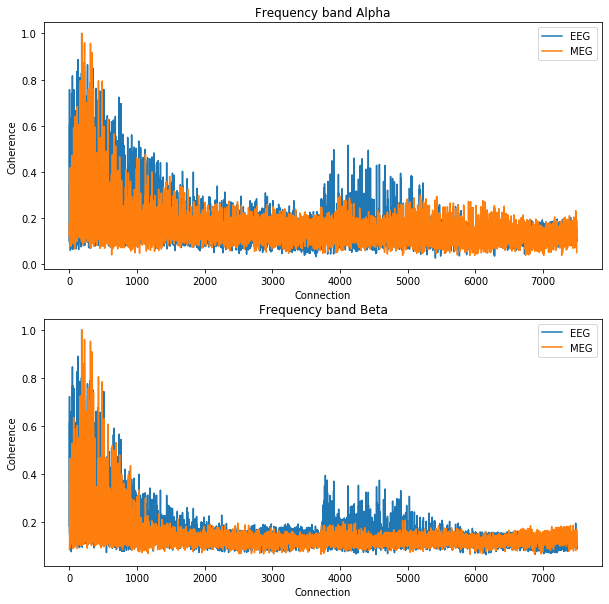

In [19]:
# Plot EEG & MEG data of both frequency bands (alpha, beta)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
plt.plot(coh_eeg[:,0], label="EEG")
plt.plot(coh_meg[:,0], label="MEG")
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")
plt.title("Frequency band Alpha")
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(coh_eeg[:,1], label="EEG")
plt.plot(coh_meg[:,1], label="MEG")
plt.title("Frequency band Beta")
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")
plt.legend()

Text(0, 0.5, 'Coherence')

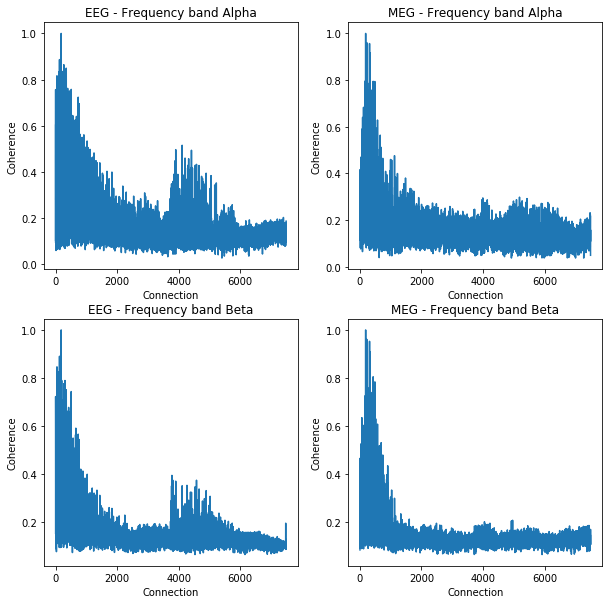

In [21]:
# Plot same information as above but in different sub-plots
# Separation of EEG & MEG analysis

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plt.plot(coh_eeg[:,0])
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")
plt.title("EEG - Frequency band Alpha")

ax = plt.subplot(2,2,2)
plt.plot(coh_meg[:,0])
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")
plt.title("MEG - Frequency band Alpha")


ax = plt.subplot(2,2,3)
plt.plot(coh_eeg[:,1], label="EEG")
plt.title("EEG - Frequency band Beta")
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")

ax = plt.subplot(2,2,4)
plt.plot(coh_meg[:,1])
plt.title("MEG - Frequency band Beta")
ax.set_xlabel("Connection")
ax.set_ylabel("Coherence")


### Print some simple statistics about both frequency bands 

In [22]:
print("Statistics frequency band Alpha (EEG first, MEG second)")
for ray in [coh_eeg[:,0], coh_meg[:,0]]:
    print(f"\taverage: {np.mean(ray)}")
    print(f"\tmedian: {np.median(ray)}")
    print(f"\tvariance: {np.var(ray)}")
    print(f"\tmax value: {np.max([x for x in ray if x < 0.999999])}")
    print(f"\tmin value: {np.min(ray)}")
    print(f"\tstd value: {np.std(ray)}")
    print("\n")
    
print("Statistics frequency band Beta (EEG first, MEG second)")
for ray in [coh_eeg[:,1], coh_meg[:,1]]:
    print(f"\taverage: {np.mean(ray)}")
    print(f"\tmedian: {np.median(ray)}")
    print(f"\tvariance: {np.var(ray)}")
    print(f"\tmax value: {np.max([x for x in ray if x < 0.999999])}")
    print(f"\tmin value: {np.min(ray)}")
    print(f"\tstd value: {np.std(ray)}")
    print("\n")
    

Statistics frequency band Alpha (EEG first, MEG second)
	average: 0.16030096479934142
	median: 0.13322532030831868
	variance: 0.010177400352555259
	max value: 0.8864785314130759
	min value: 0.02496458986938734
	std value: 0.10088310241341342


	average: 0.1487476734180929
	median: 0.13702021120494778
	variance: 0.00512463140452175
	max value: 0.9601151009395011
	min value: 0.03654906639722714
	std value: 0.07158653088760308


Statistics frequency band Beta (EEG first, MEG second)
	average: 0.1468307207024117
	median: 0.12683774595981612
	variance: 0.006512584898647398
	max value: 0.8900751309015784
	min value: 0.062240879497036244
	std value: 0.08070058796965111


	average: 0.13430350027047877
	median: 0.12455085226781273
	variance: 0.003339567811824746
	max value: 0.9606035528294351
	min value: 0.06307467245019166
	std value: 0.057788993864097915




In [23]:
coh_eeg.shape

(7498, 2)